In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
!pip install catboost
!pip install optuna

  Using cached MarkupSafe-2.1.5-cp38-cp38-win_amd64.whl.metadata (3.1 kB)
   ---------------------------------------- 0.0/380.1 kB ? eta -:--:--
   --------------------------------------- 380.1/380.1 kB 11.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/233.0 kB ? eta -:--:--
   --------------------------------------- 233.0/233.0 kB 13.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   --------------- ------------------------ 0.8/2.1 MB 17.4 MB/s eta 0:00:01
   ---------------------------------------  2.1/2.1 MB 22.0 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 22.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/157.3 kB ? eta -:--:--
   ---------------------------------------  153.6/157.3 kB 3.1 MB/s eta 0:00:01
   ---------------------------------------- 157.3/157.3 kB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/290.8 kB ? eta -:--:--
   -------------------

In [23]:
## import packages
from catboost import CatBoostClassifier, Pool
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.simplefilter('ignore')

In [55]:
## load data
train = pl.read_csv(r'playground-series-s4e7\train.csv')
test = pl.read_csv(r'playground-series-s4e7\test.csv')
test = test.with_columns(pl.lit(0).cast(pl.Int64).alias('Response'))

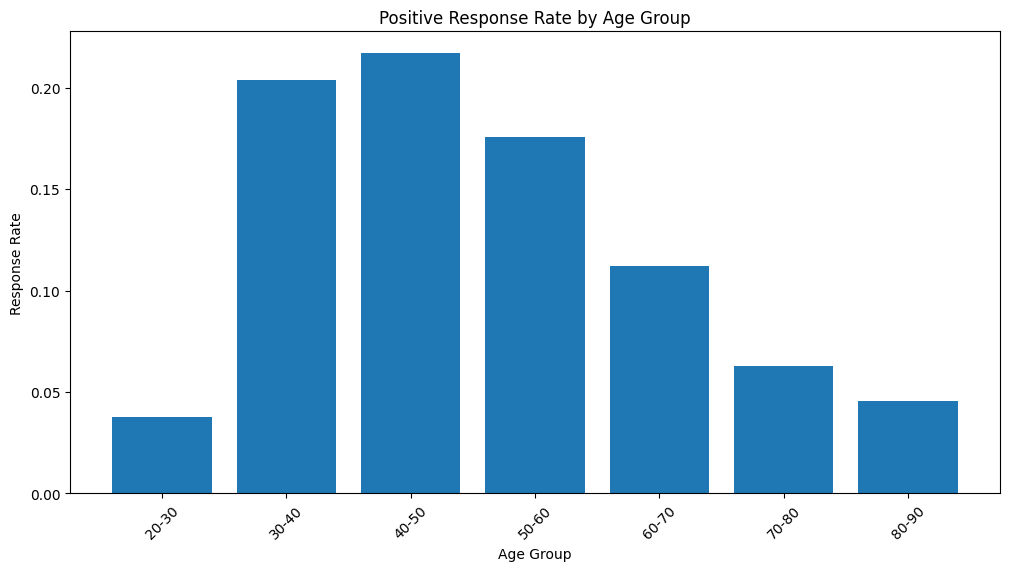

In [39]:
## load data
train = pd.read_csv(r'playground-series-s4e7\train.csv')
test = pd.read_csv(r'playground-series-s4e7\test.csv')

# 나이 구간 생성
bins = [20, 30, 40, 50, 60, 70, 80, 90]
labels = ['20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
train['Age_Group'] = pd.cut(train['Age'], bins=bins, labels=labels, right=False)
test['Age_Group'] = pd.cut(test['Age'], bins=bins, labels=labels, right=False)

# 나이대별 긍정 응답 비율 계산 ('Response'가 1인 경우)
age_response_rate = train[train['Response'] == 1].groupby('Age_Group')['Response'].count() / train.groupby('Age_Group')['Response'].count()

# 데이터프레임으로 변환
age_response_rate_df = age_response_rate.reset_index()
age_response_rate_df.columns = ['Age_Group', 'Response_Rate']

# 시각화
plt.figure(figsize=(12, 6))
plt.bar(age_response_rate_df['Age_Group'], age_response_rate_df['Response_Rate'])
plt.title('Positive Response Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Response Rate')
plt.xticks(rotation=45)
plt.show()

In [54]:
# 데이터 준비
data = {
    'Age': [22, 25, 37, 45, 52, 61, 70, 85]
}

df = pl.DataFrame(data)

# 나이 구간 설정
age_bins = [20, 30, 40, 50, 60, 70, 80, 90]
age_labels = [f'{age}-{age+10}' for age in age_bins]
print(len(age_bins), len(age_labels))
print(age_labels)
# 나이 구간화 및 새로운 열 추가
df = df.with_columns([
    df['Age'].cut(breaks=age_bins[1:], labels=age_labels).alias('Age_Binned')
])

# 결과 확인
print(df)

8 8
['20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
shape: (8, 2)
┌─────┬────────────┐
│ Age ┆ Age_Binned │
│ --- ┆ ---        │
│ i64 ┆ cat        │
╞═════╪════════════╡
│ 22  ┆ 20-30      │
│ 25  ┆ 20-30      │
│ 37  ┆ 30-40      │
│ 45  ┆ 40-50      │
│ 52  ┆ 50-60      │
│ 61  ┆ 60-70      │
│ 70  ┆ 60-70      │
│ 85  ┆ 80-90      │
└─────┴────────────┘


In [58]:
# 데이터 준비
train_data = train.clone()
test_data = test.clone()

# train_data와 test_data 합치기
df = pl.concat([train_data, test_data])

# 나이 구간 설정
age_bins = [20, 30, 40, 50, 60, 70, 80, 90]
age_labels = [f'{age}-{age+10}' for age in age_bins]
print(len(age_bins), len(age_labels))
print(age_labels)
# 나이 구간화 및 새로운 열 추가
df = df.with_columns([
    df['Age'].cut(breaks=age_bins[1:], labels=age_labels).alias('Age_Binned')
])

df

8 8
['20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']


id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Age_Binned
i64,str,i64,i64,f64,i64,str,str,f64,f64,i64,i64,cat
0,"""Male""",21,1,35.0,0,"""1-2 Year""","""Yes""",65101.0,124.0,187,0,"""20-30"""
1,"""Male""",43,1,28.0,0,"""> 2 Years""","""Yes""",58911.0,26.0,288,1,"""40-50"""
2,"""Female""",25,1,14.0,1,"""< 1 Year""","""No""",38043.0,152.0,254,0,"""20-30"""
3,"""Female""",35,1,1.0,0,"""1-2 Year""","""Yes""",2630.0,156.0,76,0,"""30-40"""
4,"""Female""",36,1,15.0,1,"""1-2 Year""","""No""",31951.0,152.0,294,0,"""30-40"""
…,…,…,…,…,…,…,…,…,…,…,…,…
19174659,"""Male""",57,1,28.0,0,"""1-2 Year""","""Yes""",51661.0,124.0,109,0,"""50-60"""
19174660,"""Male""",28,1,50.0,1,"""< 1 Year""","""No""",25651.0,152.0,184,0,"""20-30"""
19174661,"""Male""",47,1,33.0,1,"""1-2 Year""","""No""",2630.0,138.0,63,0,"""40-50"""


In [59]:
# 데이터 준비
train_data = train.clone()
test_data = test.clone()

# train_data와 test_data 합치기
df = pl.concat([train_data, test_data])

df = df.with_columns([
    pl.col('Gender').replace({'Male': 0, 'Female': 1}).cast(pl.Int32),
    pl.col('Region_Code').cast(int),
    pl.col('Vehicle_Age').replace({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}).cast(pl.Int32),
    pl.col('Vehicle_Damage').replace({'No': 0, 'Yes': 1}).cast(pl.Int32),
    pl.col('Annual_Premium').cast(int),
    pl.col('Policy_Sales_Channel').cast(int)
])

df = df.with_columns([
    (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Annual_Premium'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Annual_Premium'),
    (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Vehicle_Age'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Vehicle_Age'),
    (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Vehicle_Damage'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Vehicle_Damage'),
    (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Vintage'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Vintage')
])

# 나이 구간 설정
age_bins = [20, 30, 40, 50, 60, 70, 80, 90]
age_labels = [f'{age}-{age+10}' for age in age_bins]
df = df.with_columns([
    df['Age'].cut(breaks=age_bins[1:], labels=age_labels).alias('Age_Binned')
]).drop('Age')

train_df = df[:train_data.shape[0]].to_pandas()
test_df = df[train_data.shape[0]:].to_pandas()

cat_features = ['Gender', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage', 'Previously_Insured', 'Policy_Sales_Channel', 
                'Previously_Insured_Annual_Premium', 'Previously_Insured_Vehicle_Age', 'Previously_Insured_Vehicle_Damage', 'Previously_Insured_Vintage',
                'Age_Binned']

train_df

,id,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Previously_Insured_Annual_Premium,Previously_Insured_Vehicle_Age,Previously_Insured_Vehicle_Damage,Previously_Insured_Vintage,Age_Binned
0,0,0,1,35,0,1,1,65101,124,187,0,0,0,0,0,20-30
1,1,0,1,28,0,2,1,58911,26,288,1,1,1,0,1,40-50
2,2,1,1,14,1,0,0,38043,152,254,0,2,2,1,2,20-30
3,3,1,1,1,0,1,1,2630,156,76,0,3,0,0,3,30-40
4,4,1,1,15,1,1,0,31951,152,294,0,4,3,1,4,30-40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11504793,11504793,0,1,6,0,1,1,27412,26,218,0,5210,0,0,144,40-50
11504794,11504794,1,1,36,0,0,1,29509,152,115,1,23274,4,0,176,20-30
11504795,11504795,1,1,32,1,0,0,2630,152,189,0,18,2,1,456,20-30
11504796,11504796,1,1,28,0,1,1,48443,26,274,1,14121,0,0,124,50-60


In [60]:
## train model
aucs = []
preds = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df, train_df['Response'])):
    print(f'### Fold {fold+1} Training ###')

    X_train = train_df.loc[train_idx, [c for c in train_df.columns if c not in ['id', 'Response']]]
    y_train = train_df.loc[train_idx, 'Response']
    X_valid = train_df.loc[valid_idx, X_train.columns]
    y_valid = train_df.loc[valid_idx, 'Response']
    X_test = test_df[X_train.columns]

    X_train_pool = Pool(X_train, y_train, cat_features=cat_features)
    X_valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)
    X_test_pool = Pool(X_test, cat_features=cat_features)

    model = CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='AUC',
        learning_rate=0.05,
        iterations=5000,
        depth=9,
        random_strength=0,
        l2_leaf_reg=0.5,
        task_type='GPU',
        random_seed=42,
        verbose=False
    )

    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=1000, early_stopping_rounds=200)

    pred_valid = model.predict_proba(X_valid_pool)[:, 1]
    preds.append(model.predict_proba(X_test_pool)[:, 1])

    auc = roc_auc_score(y_valid, pred_valid)
    aucs.append(auc)

    print(f'Fold {fold+1} AUC: {auc:.5f}\n')

print(f'\nOverall AUC: {np.mean(aucs):.5f} +/- {np.std(aucs):.5f}')

### Fold 1 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8773698	best: 0.8773698 (0)	total: 1.21s	remaining: 1h 40m 24s
1000:	test: 0.8931711	best: 0.8931711 (1000)	total: 14m 18s	remaining: 57m 9s
2000:	test: 0.8934509	best: 0.8934510 (1998)	total: 28m 26s	remaining: 42m 37s
3000:	test: 0.8935313	best: 0.8935317 (2996)	total: 43m 56s	remaining: 29m 16s
4000:	test: 0.8935609	best: 0.8935645 (3937)	total: 59m 8s	remaining: 14m 46s
bestTest = 0.8935645223
bestIteration = 3937
Shrink model to first 3938 iterations.
Fold 1 AUC: 0.89356

### Fold 2 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8766343	best: 0.8766343 (0)	total: 1.52s	remaining: 2h 6m 42s
1000:	test: 0.8928002	best: 0.8928002 (1000)	total: 15m 41s	remaining: 1h 2m 42s
2000:	test: 0.8930826	best: 0.8930832 (1980)	total: 30m 38s	remaining: 45m 54s
3000:	test: 0.8931727	best: 0.8931727 (3000)	total: 46m 23s	remaining: 30m 54s
bestTest = 0.8931834996
bestIteration = 3512
Shrink model to first 3513 iterations.
Fold 2 AUC: 0.89318

### Fold 3 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8772145	best: 0.8772145 (0)	total: 865ms	remaining: 1h 12m 3s
1000:	test: 0.8930593	best: 0.8930593 (1000)	total: 14m 56s	remaining: 59m 43s
2000:	test: 0.8933214	best: 0.8933214 (2000)	total: 33m 5s	remaining: 49m 36s
3000:	test: 0.8934079	best: 0.8934086 (2966)	total: 49m 25s	remaining: 32m 55s
bestTest = 0.8934287727
bestIteration = 3683
Shrink model to first 3684 iterations.
Fold 3 AUC: 0.89343

### Fold 4 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8765780	best: 0.8765780 (0)	total: 1.05s	remaining: 1h 27m 52s
1000:	test: 0.8928077	best: 0.8928077 (1000)	total: 14m 42s	remaining: 58m 43s
2000:	test: 0.8930964	best: 0.8930964 (2000)	total: 31m 38s	remaining: 47m 24s
3000:	test: 0.8931868	best: 0.8931868 (3000)	total: 48m	remaining: 31m 58s
4000:	test: 0.8932095	best: 0.8932110 (3828)	total: 1h 24m 10s	remaining: 21m 1s
bestTest = 0.8932110071
bestIteration = 3828
Shrink model to first 3829 iterations.
Fold 4 AUC: 0.89321

### Fold 5 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8771760	best: 0.8771760 (0)	total: 1.03s	remaining: 1h 25m 41s
1000:	test: 0.8934957	best: 0.8934958 (999)	total: 22m 5s	remaining: 1h 28m 15s
2000:	test: 0.8937832	best: 0.8937832 (1998)	total: 42m 33s	remaining: 1h 3m 46s
3000:	test: 0.8938566	best: 0.8938566 (3000)	total: 1h 4m 17s	remaining: 42m 49s
4000:	test: 0.8938812	best: 0.8938853 (3800)	total: 1h 24m 58s	remaining: 21m 13s
bestTest = 0.8938853145
bestIteration = 3800
Shrink model to first 3801 iterations.
Fold 5 AUC: 0.89389


Overall AUC: 0.89345 +/- 0.00026


In [61]:
## create submission
submission = test_df[['id']]
submission['Response'] = np.mean(preds, axis=0)

submission.to_csv('submission_240718_2.csv', index=False)
submission

,id,Response
0,11504798,0.006647
1,11504799,0.679922
2,11504800,0.231421
3,11504801,0.000175
4,11504802,0.187430
...,...,...
7669861,19174659,0.184595
7669862,19174660,0.000249
7669863,19174661,0.000492
7669864,19174662,0.537388


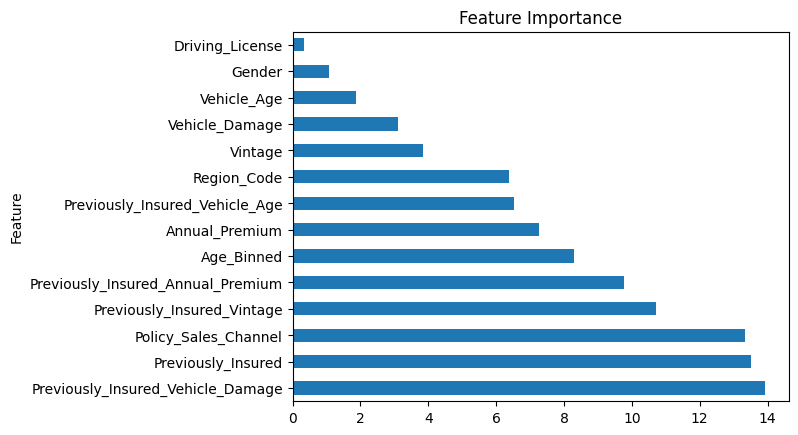

In [62]:
# Feature Importance

feature_importances = model.get_feature_importance()
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title('Feature Importance')
plt.show()